# Create TTS VITS model and TorchScript model

- 이 노트북은 VITS 모델을 생성 및  TorchScript 형태로 변화하고 추론 테스트까지를 합니다.

## 1.  Setup environment
사용하는 패키지는 import 시점에 다시 재로딩 합니다.

In [1]:
# %load_ext autoreload
# %autoreload 2

import sys, os
sys.path.append(os.path.abspath("./vits"))
# sys.path.append('./vits')
for i in sys.path:
    print(i)

/home/ec2-user/anaconda3/envs/conda-vits-py310/lib/python310.zip
/home/ec2-user/anaconda3/envs/conda-vits-py310/lib/python3.10
/home/ec2-user/anaconda3/envs/conda-vits-py310/lib/python3.10/lib-dynload

/home/ec2-user/anaconda3/envs/conda-vits-py310/lib/python3.10/site-packages
/home/ec2-user/SageMaker/lab/00-trition-tts-vits/02-tts-vits-docker-trition/vits


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import os
import json
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import commons
import utils
from data_utils import TextAudioLoader, TextAudioCollate, TextAudioSpeakerLoader, TextAudioSpeakerCollate
from models import SynthesizerTrn
from text.symbols import symbols
from text import text_to_sequence

from scipy.io.wavfile import write

## 2. Load LJ Speech Model
- [Important] Downlaod models to vits/models/
    - https://drive.google.com/drive/folders/1ksarh-cJf3F5eKJjLVWY0X1j1qsQqiS2
- 이 코드는 VITS TTS 모델에서 텍스트를 전처리하는 부분입니다. 
    - 처리 순서 : 1/ 설정파일 로드 (ljs_base.json) 2/입력테스트를 get_text 함수 이용한 전처리 3/전처리된 텍스트를 모델에 입력하여 음성 생성

In [3]:
def get_text(text, hps):
    text_norm = text_to_sequence(text, hps.data.text_cleaners) #텍스트를 숫자로 변환
    if hps.data.add_blank: #필요한 경우, 텍스트 토큰 사이에 빈칸(0)을 추가
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm) #최종적으로 PyTorch 텐서로 변환
    return text_norm

hps = utils.get_hparams_from_file("vits/configs/ljs_base.json") #LJ Speech 데이터셋으로 학습된 모델의 설정 파일임

* 이 코드는 VITS 모델을 로드하고 초기화하는 부분입니다.
    - 1/모델 구조 생성 및 GPU 이동 2/추론 모드로 전환 3/사전학습된 가중치 로드 
    - 이렇게 설정된 모델은 텍스트를 입력받아 음성을 생성할 수 있는 상태가 됩니다! 

In [4]:
# 모델 초기화
net_g = SynthesizerTrn(  #VITS의 메인 모델 클래스로 Trn = Transformer임
    len(symbols), #입력 심볼 (텍스트) 개수
    hps.data.filter_length // 2 + 1, #스펙트로그램 특성 크기 ; filter_length --> 오디오 신호 처리를 위한 필터 길이
    hps.train.segment_size // hps.data.hop_length, #hop_length: 오디오 프레임 간 간격
    **hps.model).cuda() #모델 설정값 ; .cuda()-->GPU로 모델 이동

# 평가 모드 설정
_ = net_g.eval() #모델을 추론(평가) 모드로 설정; dropout 등 학습용 레이어들이 비활성화됨

# 사전 학습된 가중치 로드 : 가중치파일, 가중치 로드할 모델, 옵티마이저(추론시는 불필요라 None)
_ = utils.load_checkpoint("vits/models/pretrained_ljs.pth", net_g, None) #pretrained_ljs.pth --> LJSpeech 데이터셋으로 학습된 모델 가중치 파일

In [5]:
text = "Hello, how are you? I'd like to introduce myself"
text_norm = get_text(text, hps)

with torch.no_grad():
    # 입력 텍스트를 GPU로 이동하고 배치 차원 추가
    x_tst = text_norm.cuda().unsqueeze(0)
    
    # 텍스트 길이 정보 생성 및 GPU로 이동
    x_tst_lengths = torch.LongTensor([text_norm.size(0)]).cuda()
    
    # 모델 추론
    result = net_g.infer(
        x_tst,              # 입력 텍스트
        x_tst_lengths,      # 텍스트 길이
        noise_scale=.667,   # 음성 변화도
        noise_scale_w=0.8,  # 음성 다양성
        length_scale=1      # 발화 속도
    )
    
    # 오디오 데이터 추출
    audio = result[0][0,0].data.cpu().float().numpy()

# Jupyter에서 오디오 재생
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate, normalize=False))

## 3. Create input text, inference and play it

In [6]:
stn_tst = get_text("Claude is AI for all of us. Whether you're brainstorming alone or building with a team of thousands, Claude is here to help", hps)
# stn_tst = get_text("VITS is Awesome!", hps)
with torch.no_grad():
    x_tst = stn_tst.cuda().unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).cuda()
    result = net_g.infer(x_tst, x_tst_lengths, noise_scale=.667, noise_scale_w=0.8, length_scale=1)
    audio = result[0][0,0].data.cpu().float().numpy()    
    # audio = net_g.infer(x_tst, x_tst_lengths, noise_scale=.667, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()

ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate, normalize=False))

## 4. Analyze output

In [7]:
len(result), result[0].shape, result[1].shape, result[2].shape
# 4 : 모델이 반환하는 튜플의 길이가 4 > 4개의 요소
# result[0].shape [1,1,168704] : 생성된 오디오파형 : 1 배치크기, 1 오디오 채널, 168704 오디오샘플수
# result[1].shape [1,1,659,257] : 스펙트로그램 데이터 : 1 배치크기, 1 채널, 659 시간 스페임 수, 257 주파수 빈(bin)의 수
# result[2].shape [1,1,659] : 정렬(alignment) 또는 시간 정보 : 1 배치크기,1 채널,659 시간 프레임 수 (스펙스로그램 시간 차원과 일치)

(4,
 torch.Size([1, 1, 174592]),
 torch.Size([1, 1, 682, 257]),
 torch.Size([1, 1, 682]))

In [8]:
result[0][0,0].data.cpu().float().numpy()    

array([-0.00081826, -0.00080434, -0.00102894, ...,  0.00047121,
        0.00052841,  0.00047018], dtype=float32)

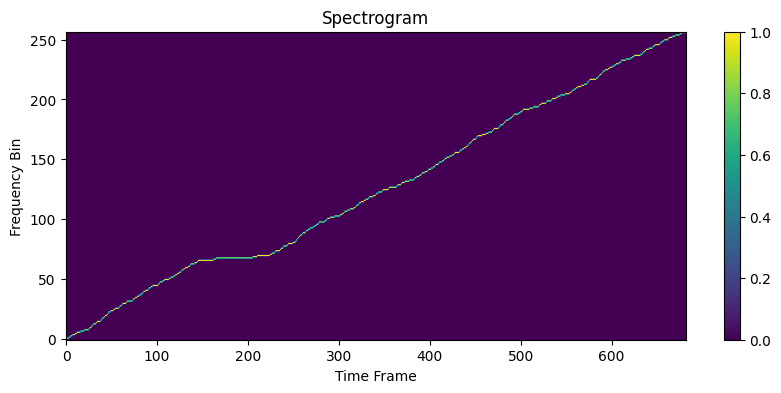

In [9]:
# 오디오 파형 추출 및 재생
audio_wave = result[0][0, 0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio_wave, rate=22050))

# 스펙트로그램 시각화 (필요한 경우)
import matplotlib.pyplot as plt

spec = result[1][0, 0].data.cpu().numpy()
plt.figure(figsize=(10, 4))
plt.imshow(spec.T, aspect='auto', origin='lower')
plt.colorbar()
plt.title('Spectrogram')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.show()

## 5. Prepare Trace model

### Create Wrapped Model
* VITS 모델을 래핑 (wrapping)하는 클래스를 정의함; TRITON 서버에서 사용하기 위해 모델을 단순화하는 목적임
    * 단순화 가능 : 원본 모델이 반환하는 여러 값들 중 필요한 오디오 파형만 반환; TRITON 서버에서 처리하기 더 쉬워짐
    * 인터페이스 표준화 : PyTorch의 표준적인 forward 메소드 사용; 다른 시스템과의 호환성 향상

In [10]:
# 클래스 정의 : torch.nn.Module을 상속받아 pytorch 모델 구조를 따름
class WrappedModel(torch.nn.Module):
    def __init__(self, model: SynthesizerTrn): # 생성자에서 원본 VITS 모델(SynthesizerTrn)을 받아 저장
        super().__init__()
        self.model = model
# Forward 메소드 : 모델의 추론 로직을 정의 ; 기본 매개변수 값들을 미리 설정
    def forward(
        self,
        x, #입력 텍스트
        x_lengths, # 텍스트 길이
        noise_scale=0.667, #음성 변화도
        length_scale=1.0, # 발화 속도
        noise_scale_w=0.8, # 음성 다양성
    ):
        # 추론 과정 : 원본 모델 infer 매소드 호출
        return self.model.infer(
            x=x,
            x_lengths=x_lengths,
            noise_scale=noise_scale,
            length_scale=length_scale,
            noise_scale_w=noise_scale_w,
        )[0] #오디오 파형만 반환

In [11]:
model = WrappedModel(net_g)
model = model.eval()


### Create Dummpy inputs 
* VITS 모델에 입력할 텐서들을 준비하는 과정을 보여줍니다.
    * 1/실제 텍스트 대신 랜덤 숫자 사용 2/파라미터들은 텐서로 생성 3/모든 값을 명시적으로 GPU로 이동

In [12]:
# 입력 텍스트 텐서 생성
x = torch.randint(low=1, high=10, size=(10,), dtype=torch.int64) # 1-9 사이 랜덤 정수 10개 생성; 텍스트를 숫자로 변환한 시퀀스 들어감
# 배치 차원 추가 및 GPU 이동
x = x.unsqueeze(0).cuda() #unsqueeze(0) : [10]--> [1,10] 배치 차원 추가
# 텍스트 길이 텐서 생성
x_length = torch.tensor([x.shape[1]], dtype=torch.int64).cuda()

# 출력 예시
print("x: \n", x) #텐서
print("x: ", x.shape) # 배치크기, 시퀀스 길이
print("x_length shape: ", x_length.shape) #텐서
print("x_length: ", x_length) #토치 사이즈

# 생성 파라미터 설정; 모두 GPU 텐서로 생성
noise_scale = torch.tensor([1], dtype=torch.float32).cuda()
length_scale = torch.tensor([1], dtype=torch.float32).cuda()
noise_scale_w = torch.tensor([1], dtype=torch.float32).cuda()

x: 
 tensor([[4, 7, 4, 1, 1, 3, 5, 5, 8, 3]], device='cuda:0')
x:  torch.Size([1, 10])
x_length shape:  torch.Size([1])
x_length:  tensor([10], device='cuda:0')


## 6. Create Trace Model 
* Pytorch 모델을 TorchScript 형태로 변환하는 과정을 보여줌 
* 이 과정이 필요한 이유
    * 모델 최적화
    * TRITON 서버 배포 목적

In [13]:
# Dummy input 준비
dummy_input = (x, x_length, noise_scale, length_scale, noise_scale_w)
trace_model = torch.jit.trace(model, dummy_input)
# 모델을 torchScript로 변환 : 최적화된 C++ 코드 실행
# dummy_input으로 한번 실행하면서 모델의 연산 그래프를 추적


/home/ec2-user/SageMaker/lab/00-trition-tts-vits/02-tts-vits-docker-trition/vits/attentions.py:157: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t_s == t_t, "Relative attention is only available for self-attention."
/home/ec2-user/SageMaker/lab/00-trition-tts-vits/02-tts-vits-docker-trition/vits/attentions.py:202: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  pad_length = max(length - (self.window_size + 1), 0)
/home/ec2-user/SageMaker/lab/00-trition-tts-vits/02-tts-vits-docker-trition/vits/attentions.py:203: TracerWarning: Converting a tensor 

### Save model and test loading
* TorchScript로 변환된 모델을 저장하고 다시 불러오는 과정입니다.

In [14]:
workspace_folder = "workspace"
os.makedirs(workspace_folder, exist_ok=True)
# 모델 저장 경로 설정
model_path = "trace_vits.pt"
model_path = os.path.join(workspace_folder, model_path)
# 모델 저장
trace_model.save(model_path)
print("#### Load Test ####")    
loaded_m = torch.jit.load(model_path)    
# print(loaded_m.code)    


#### Load Test ####


### Inference on the loaded model

In [15]:
result = loaded_m(x_tst, x_tst_lengths, noise_scale, length_scale, noise_scale_w)
print("Result : \n", result.shape)
result = result[0,0].data.cpu().float().numpy()
print("Output value : \n", result.shape)

Result : 
 torch.Size([1, 1, 179712])
Output value : 
 (179712,)


### Play output array data

In [16]:
ipd.display(ipd.Audio(result, rate=hps.data.sampling_rate, normalize=False))